In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

f=open("/content/DogMoveData.csv","r")
dogmove_data=pd.read_csv(f,header=0)
seq=dogmove_data[['ABack_x','ABack_y','ABack_z','ANeck_x', 'ANeck_y', 'ANeck_z', 'GBack_x', 'GBack_y', 'GBack_z', 'GNeck_x', 'GNeck_y', 'GNeck_z']].to_numpy()

In [ ]:
# 시계열 데이터를 윈도우 단위로 자르는 함수
# 단순하게 데이터를 10초단위로 묶음.
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=dogmove_data['Behavior_1'][i+window-1] #윈도우 크기의 데이터. 마지막 행동을 y로 설정
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w=100 # 윈도우 크기 # (0.1 * 100) = 10초동안의 데이터를 하나의 윈도우로 묶음
h=1 # 수평선 계수

X,Y = seq2dataset(seq,w,h)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y_encoder = encoder.transform(Y)
Y_encoder

# 훈련 집합과 테스트 집합으로 분할
x_train, x_test, y_train, y_test = train_test_split(X, Y_encoder, train_size=0.6)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

hidden_units = 128
num_classes = 13 #len(set(Y))의 값. seq2dataset 메소드를 통해 나눈 class의 종류를 의미함. 좀 더 의미있게 데이터를 나누기 위해 메소드 수정을 통해 이 값도 앞으로 수정되어야 함.

model = Sequential()
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks=[es, mc], validation_data=(x_test, y_test))

Epoch 1/100
1164/1165 [============================>.] - ETA: 0s - loss: 0.7652 - acc: 0.7360
Epoch 1: val_acc improved from -inf to 0.82020, saving model to best_model.h5
1165/1165 [==============================] - 20s 12ms/step - loss: 0.7652 - acc: 0.7360 - val_loss: 0.5219 - val_acc: 0.8202
Epoch 2/100
1162/1165 [============================>.] - ETA: 0s - loss: 0.3460 - acc: 0.8812
Epoch 2: val_acc improved from 0.82020 to 0.90004, saving model to best_model.h5
1165/1165 [==============================] - 13s 11ms/step - loss: 0.3459 - acc: 0.8812 - val_loss: 0.2961 - val_acc: 0.9000
Epoch 3/100
1165/1165 [==============================] - ETA: 0s - loss: 0.2376 - acc: 0.9200
Epoch 3: val_acc improved from 0.90004 to 0.93221, saving model to best_model.h5
1165/1165 [==============================] - 13s 11ms/step - loss: 0.2376 - acc: 0.9200 - val_loss: 0.2056 - val_acc: 0.9322
Epoch 4/100
1165/1165 [==============================] - ETA: 0s - loss: 0.2033 - acc: 0.9320
Epoch 4: 

손실 함수: 0.04231945797801018 정확도: 0.9857584238052368


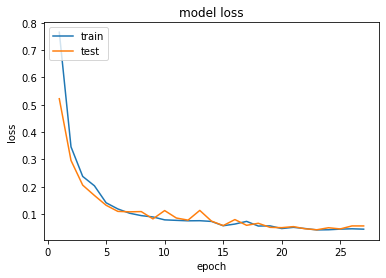

In [ ]:
from tensorflow.keras.models import load_model

# LSTM 모델 평가
loaded_model = load_model('best_model.h5')
ev=loaded_model.evaluate(x_test,y_test,verbose=0)
print("손실 함수:",ev[0],"정확도:",ev[1])

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()